# Hands-on Introduction to Deep Learning for Early Warnings of Tipping Points

## Practical Session
As we have learned the basics of DL and how it is used to anticipate tipping points, it is your turn to improve your understanding the CNN-LSTM architecture and how choices such as detrending and kernel size can affect the predictions and uncertainty of predictions from trained DL models. Most of the models are already pretrained using a similar procedure to those seem in the lecture. I am hoping, we may be able to use the limited resources on [Google Colab](https://colab.research.google.com/) free version to train the model in the last example. The code for the first exercise has already been written and it may be adopted for the subsequent exercises.

It should be noted that the goal of these exercises is not to teach you PyTorch but to understand how the choice of hyperparameters of a DL model and the preprocessing of the training data can determine whether your deep learning model has good early warning skills or not.


This notebook can be open in Google Colab via this [link](https://colab.research.google.com/github/muhammedfadera/DL4EWS-Dartington/blob/master/practical_session.ipynb).

In [1]:
import os

if not os.path.exists("/content/DL4EWS-Dartington"):
    !git clone https://github.com/muhammedfadera/DL4EWS-Dartington.git


Cloning into 'DL4EWS-Dartington'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 108 (delta 29), reused 44 (delta 16), pack-reused 50 (from 2)
Receiving objects: 100% (108/108), 118.31 MiB | 11.73 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Updating files: 100% (46/46), done.


In [2]:
!pip install statsmodels scipy

In [4]:
%cd DL4EWS-Dartington

/content/DL4EWS-Dartington


In [5]:
%ls

data/                         pictures/                utilities.py
feedforwardNNs_pytorch.ipynb  practical_session.ipynb  visualising_sgd.py
gen_data.py                   PreTrainedModels/
Intro_to_DL_for_EWS.ipynb     README.md


In [6]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import random
from utilities import *


# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else ""
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
device = "cuda"

torch.manual_seed(16022026)
np.random.seed(16022026)



class CNN_LSTM_TippingClassifier(torch.nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 2,
                 n_features = 10, seq_length = 1500,
                 kernel_size = 12):
       super(CNN_LSTM_TippingClassifier, self).__init__()


       self.conv = nn.Sequential(
        #  convolution
        nn.Conv1d(
            in_channels=input_size, out_channels=n_features,
            kernel_size=kernel_size, padding=0, stride=1
        ),
        # dropout with 0.1 probability
        nn.Dropout(0.1),
        # max pool
        nn.MaxPool1d(kernel_size=kernel_size, stride = 1, padding=0)
       )
       moving_window = 2*(kernel_size - 1)
       n_out = seq_length - moving_window
       self.n_out = n_out
       self.n_features = n_features
       self.input_size = input_size
       self.RNN = nn.LSTM(input_size=n_features, hidden_size=hidden_size, bias=True,
                          num_layers=2, batch_first=True)
       self.Wout = nn.Linear(in_features=hidden_size*n_out, out_features=output_size)
       with torch.no_grad():
           nn.init.sparse_(self.Wout.weight, sparsity=0.99, std=1/np.sqrt(n_out))
           nn.init.zeros_(self.Wout.bias)
       self.flatten = nn.Flatten()
       self.hidden_size = hidden_size

    def forward(self, X):
        # batch_size, input_size, seq_len = X.shape
        X = self.conv(X)
        X = X.view(-1, self.n_out, self.n_features)
        y_pred, _ = self.RNN(X) # RNN gives two outputs, we want to the first one
        y_pred = torch.softmax(self.Wout(self.flatten(y_pred)), dim = -1)
        return y_pred



### CNN-LSTM architecture for predicting tipping

**1. In the CNN-LSTM example, Kernel size is equivalent to rolling/moving window size in critical slowing-based methods**

In lectures, the output of the model shown had a kernel with a size of $5$. We have trained 4 models with kernel sizes $7$, $15$ and $50$ on the same training data. Using the plotting function `plot_model_on_test` in `utilities.py`, compare the predicted outputs of these with each other and the one seen in the lecture. If you want to see how the prediction for a single tipping trajectory compare to a single non-tipping trajectory, set the `n_plots` argument to $1$ and `plot_mean` to `False`

In [7]:

filenames = [("X_train_null_detrended_lowess.txt", "X_test_null_detrended_lowess.txt"),
             ("X_train_saddlenode_detrended_lowess.txt", "X_test_saddlenode_detrended_lowess.txt")]
class_labels = [0, 1]

X_train_lowess, y_train_lowess, X_test_lowess, y_test_lowess = read_X_y_data(
    class_labels=class_labels,
    train_test_files=filenames,
    detrend=False
)

X_test_lowess = X_test_lowess.unsqueeze(dim = 1).to(device)

In [10]:
rnn_modelk7path = "PreTrainedModels/CNN_LSTM_kernel_size=7_hidden_size=50_features=50_smoothing=lowess_model_weights.pth"
rnn_modelk7 = CNN_LSTM_TippingClassifier(
    hidden_size=50, n_features=50, kernel_size=7, input_size=1, output_size=2
).to('cuda')

rnn_modelk7.load_state_dict(torch.load(rnn_modelk7path))

RuntimeError: torch.UntypedStorage(): Storage device not recognized: mps

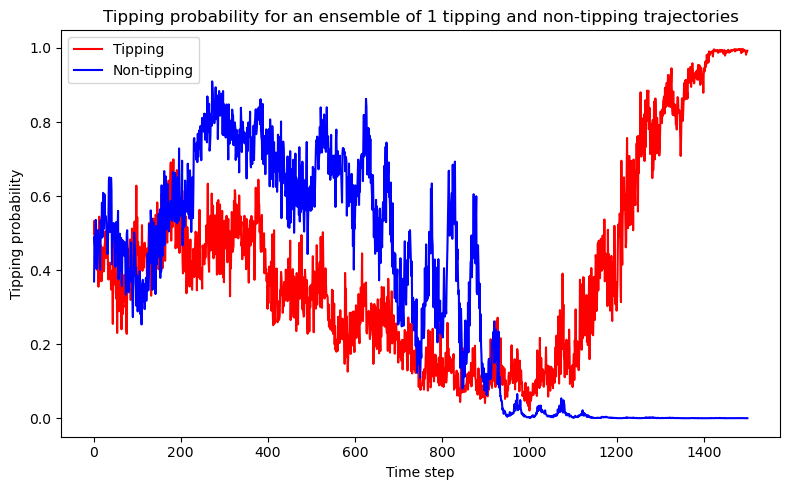

In [ ]:
plot_model_on_test(rnn_modelk7, X_test_lowess, y_test_lowess, n_plots=1, plot_mean=False)

<Figure size 800x500 with 0 Axes>

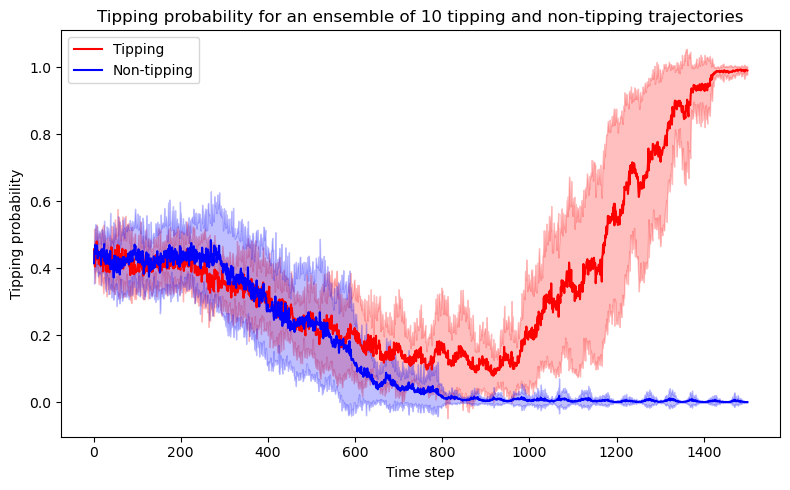

In [ ]:
plot_model_on_test(rnn_modelk7, X_test_lowess, y_test_lowess, n_plots=10, plot_mean=True)

In [ ]:

rnn_modelk15path = "PreTrainedModels/CNN_LSTM_kernel_size=15_hidden_size=50_features=50_smoothing=Lowess_model_weights.pth"
rnn_modelk15 = CNN_LSTM_TippingClassifier(
    hidden_size=50, n_features=50, kernel_size=15, input_size=1, output_size=2
).to(device)

rnn_modelk15.load_state_dict(torch.load(rnn_modelk15path))

<All keys matched successfully>

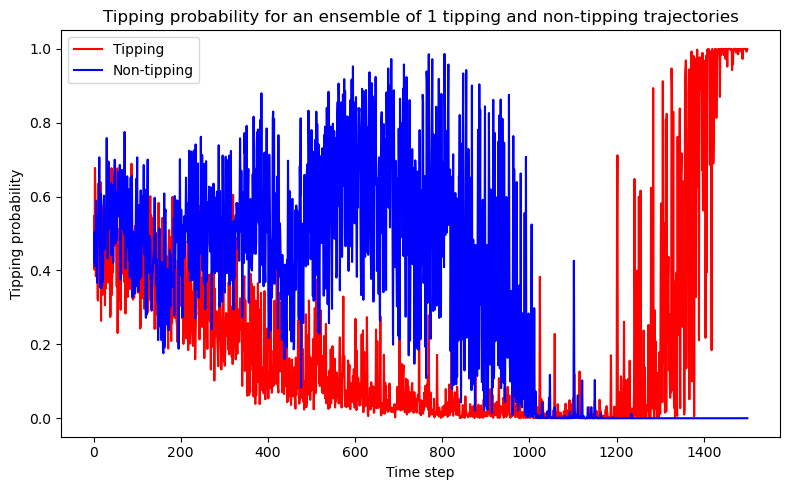

In [ ]:
plot_model_on_test(rnn_modelk15, X_test_lowess, y_test_lowess, n_plots=1, plot_mean=False)

<Figure size 800x500 with 0 Axes>

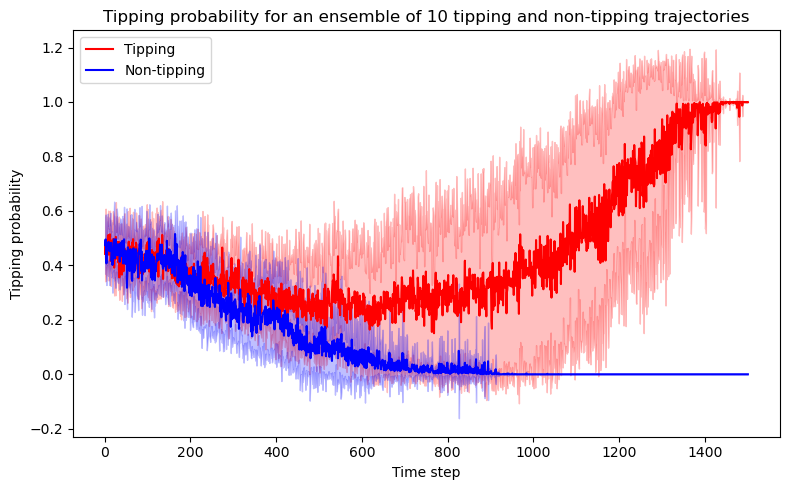

In [ ]:

plot_model_on_test(rnn_modelk15, X_test_lowess, y_test_lowess, n_plots=10, plot_mean=True)

In [ ]:

rnn_modelk50path = "PreTrainedModels/CNN_LSTM_kernel_size=50_hidden_size=50_features=50_smoothing=Lowess_model_weights.pth"
rnn_modelk50 = CNN_LSTM_TippingClassifier(
    hidden_size=50, n_features=50, kernel_size=50, input_size=1, output_size=2
).to(device)


rnn_modelk50.load_state_dict(torch.load(rnn_modelk50path))

<All keys matched successfully>

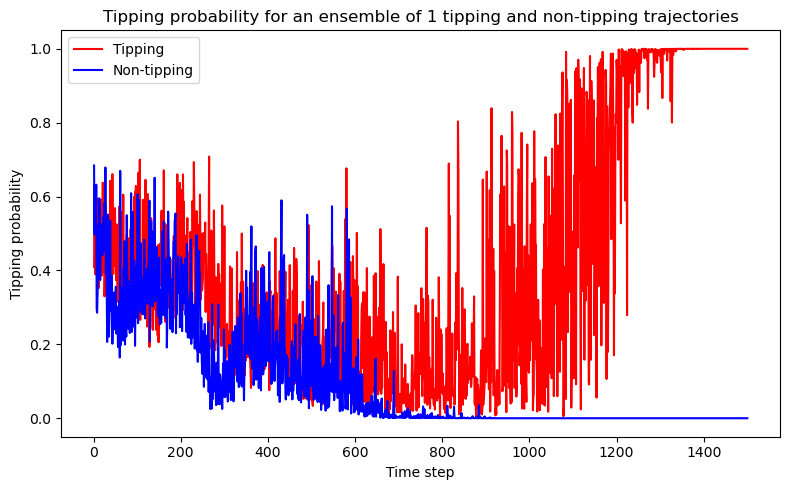

In [ ]:

plot_model_on_test(rnn_modelk15, X_test_lowess, y_test_lowess, n_plots=1, plot_mean=False)

<Figure size 800x500 with 0 Axes>

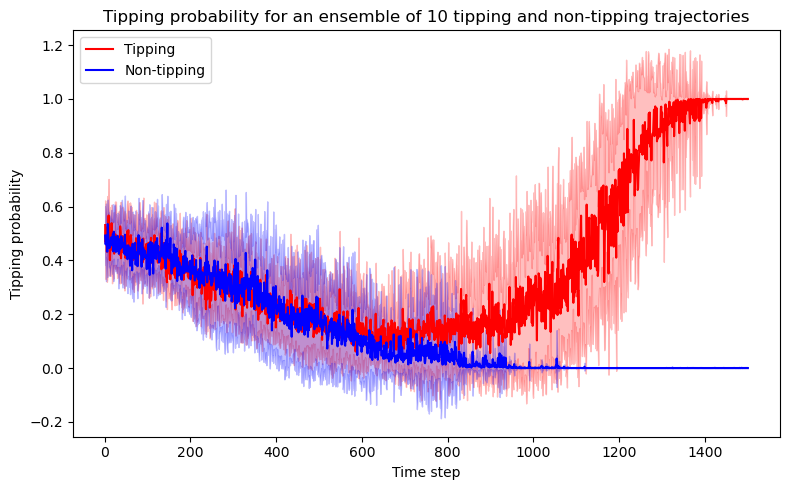

In [ ]:

plot_model_on_test(rnn_modelk15, X_test_lowess, y_test_lowess, n_plots=10, plot_mean=True)

It can be seen that with smaller kernel size, your result tend to be smoother while larger kernel sizes tend to give noiser predictions. In fact, if you do not use a CNN and just apply an RNN to the time series, it may just learn the smoothed version of the time series which may not be useful for anticipating tipping. However, large kernel sizes usually require larger training set to reach convergence since the will be more trainable parameters. Thus a trade-off must be made between too large or too small kernel sizes. Notice also that the uncertanty remain large for small kernel sizes at all lead times while large kernel sizes tend to have smaller uncertanity close to tipping.  In application such as image processing where CNNs are used heavily, kernel sizes of more than $7$ are very unusual. Unless their is need, kernel sizes of between $3$ to $15$ should be sufficient for most applications of CNNs.



**2. The role of detrending**

There is some evidence that the choice of detrending and parameters such as bandwidth can result in vastly different performances for the same DL model (see [Deblander and Bury 2022](https://www.pnas.org/doi/10.1073/pnas.2207720119)). The main choices are detrending by `Gaussian` smoothing (similar to [Nadaraya-Watson Kernel Smoothing](https://en.wikipedia.org/wiki/Kernel_regression)) or smoothing by [locally weighted regression](https://en.wikipedia.org/wiki/Local_regression) (`lowes`). In some scenarios, it may not be necessary to detrend the data e.g when predicting rate-induced tipping ([Huang et al. 2024](https://www.nature.com/articles/s42256-024-00937-0)). Here we will compare the performance of the `CNN_LSTM_TippingClassifier` when now supplied with data detrended via `Gaussian` smoothing. Two models stored in

1. `PreTrainedModels/CNN_LSTM_kernel_size=5_hidden_size=50_features=50_smoothing=Gaussian_model_weights.pth` and

2. `PreTrainedModels/CNN_LSTM_kernel_size=50_hidden_size=50_features=50_smoothing=Gaussian_model_weights.pth`

were trained on the Gaussian detrended data. Following the code from the previous exercise,


-  load the models

-  predict the tipping probability using each model. How do the predictions and their uncertainities compare to those from the models trained with Lowess detrended data?



In [ ]:

filenames = [("X_train_null_detrended_gaussian.txt", "X_test_null_detrended_gaussian.txt"),
             ("X_train_saddlenode_detrended_gaussian.txt", "X_test_saddlenode_detrended_gaussian.txt")]
class_labels = [0, 1]

X_train_gaussian, y_train_gaussian, X_test_gaussian, y_test_gaussian = read_X_y_data(
    class_labels=class_labels,
    train_test_files=filenames,
    detrend=False
)

X_test_gaussian = X_test_gaussian.unsqueeze(dim = 1).to(device)

In [ ]:

# load model with kernel size 5
rnn_model_gaussiank5 =  CNN_LSTM_TippingClassifier(
    hidden_size=50, n_features=50, kernel_size=5, input_size=1, output_size=2
).to(device)
rnn_model_gaussiank5.load_state_dict(torch.load("PreTrainedModels/CNN_LSTM_kernel_size=5_hidden_size=50_features=50_smoothing=Gaussian_model_weights.pth"))



rnn_model_gaussiank50 = CNN_LSTM_TippingClassifier(
    hidden_size=50, n_features=50, kernel_size=50, input_size=1, output_size=2
).to(device)
rnn_model_gaussiank50.load_state_dict(torch.load("PreTrainedModels/CNN_LSTM_kernel_size=50_hidden_size=50_features=50_smoothing=Gaussian_model_weights.pth"))

<All keys matched successfully>

In [ ]:
plot_model_on_test(rnn_model_gaussiank5, X_test_gaussian, y_test_gaussian, n_plots=1, plot_mean=False)
plot_model_on_test(rnn_model_gaussiank5, X_test_gaussian, y_test_gaussian, n_plots=10, plot_mean=True)

In [ ]:

plot_model_on_test(rnn_model_gaussiank50, X_test_gaussian, y_test_gaussian, n_plots=1, plot_mean=False)
plot_model_on_test(rnn_model_gaussiank50, X_test_gaussian, y_test_gaussian, n_plots=10, plot_mean=True)


`Lowess` smoothing is very computational expensive as it fits a separate linear regression model in a given neighbourhood (the size of this neighbourhood is known as the span or bandwidth) but it tend to yield better performing models. On the other hand, `Gaussian` smoothing is extremely fast but DL models trained with this tend to have poor predictive skills.


**3. Classifying the nature of tipping (may not be possible to do during practical sessions)**

The goal of this exercise is to train your own model to classify between a null model, sadddlenode and transcritical bifurcations, making informed choices on the kernel size and other hyperparameters of the `CNN_LSTM_TippingClassifer` class, and the choice of detrending. The files

1. `data/X_train_transcritical_detrended_gaussian.txt`,

2. `data/X_train_transcritical_detrended_lowess.txt`,

3. `data/X_test_transcritical_detrended_gaussian.txt` and

4. `data/X_test_transcritical_detrended_lowess.txt`

contain the corresponding detrended time series for transcritical bifurcation. Use the utility function `prepare_train_test_data` to add shorter sequences and/or control batch size of the training set. Shorter training sequences improve skills at larger lead times away from tipping. The code for training on Gaussian detrended data with kernel size of $7$ has been provided.

>- I am hoping we can run some of this training on Google Colab free version but the compute for this plan is limited. Alternatively, you can run the model locally on either GPU or CPU.



In [ ]:

np.random.seed(16022026)
torch.manual_seed(16022026)
from utilities import *


filenames = [("X_train_null_detrended_gaussian.txt", "X_test_null_detrended_gaussian.txt"),
             ("X_train_saddlenode_detrended_gaussian.txt", "X_test_saddlenode_detrended_gaussian.txt"),
             ("X_train_saddlenode_detrended_gaussian.txt", "X_test_saddlenode_detrended_gaussian.txt")]
class_labels = [0, 1]

X_train_gaussian_tc, y_train_gaussian_tc, X_test_gaussian_tc, y_test_gaussian_tc = read_X_y_data(
    class_labels=class_labels,
    train_test_files=filenames,
    detrend=False
)


# also you can add shorter sequences to training set. This improve early warning skill on short sequences
# and larger lead times
X_train_gaussian_tc, y_train_gaussian_tc, X_test_gaussian_tc, y_test_gaussian_tc = \
    prepare_train_test_data(X_train_gaussian_tc, y_train_gaussian_tc,
                            X_test_gaussian_tc, y_test_gaussian_tc,
                            num_batches=10,  # increase number of batches if you have memory errors
                            device=device, shorter_sequences=True)


rnn_model_gaussiank7tc = CNN_LSTM_TippingClassifier(
    hidden_size=50, n_features=50, kernel_size=7, input_size=1, output_size=3 # three classes
).to(device)


loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(rnn_model_gaussiank7tc.parameters(),
                             lr=0.00005, # lr is the learning rate,
                             )

In [ ]:

n_epochs = 2000 # may want to reduce this
print_every = 10
train_losses = []
test_losses = []

train_losses, test_losses = train(rnn_model_gaussiank7tc,
                                  X_train_gaussian_tc, y_train_gaussian_tc,
                                  X_test_gaussian_tc, y_test_gaussian_tc,
                                  loss_fn, optimizer, train_losses,
                                  test_losses, n_epochs, print_every)


plot_train_and_test_loss(train_losses, test_losses)

In [ ]:

plot_model_on_test(rnn_model_gaussiank7tc, X_test_gaussian_tc, y_test_gaussian_tc, n_plots=1, plot_mean=False)
plot_model_on_test(rnn_model_gaussiank7tc, X_test_gaussian_tc, y_test_gaussian_tc, n_plots=10, plot_mean=True)